In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Markdown

%matplotlib inline

In [2]:
%%html 
<style>
table {float:left; border-style: solid;}
</style>

Utils

In [3]:
# util to classify variables into categorical or quantitative
def classify_variables(df: pd.DataFrame):
    '''
    Given a dataframe, returns two lists: a list of the categorical variables 
    in the dataframe and a list of the quantitative ones, based on the dtypes.
    '''
    cols = df.columns.to_list()
    quantitative_cols = df.select_dtypes('number').columns.to_list()
    categorical_cols = df.select_dtypes('object').columns.to_list()
    display(Markdown("#### Features in the dataset"))
    print("Count:", len(cols), "\nFeatures:", cols)
    display(Markdown("#### Categorical Features"))
    print("Count:", len(categorical_cols), "\nFeatures:", categorical_cols)
    display(Markdown("#### Continuous Features"))
    print("Count:", len(quantitative_cols), "\nFeatures:", quantitative_cols)
    return categorical_cols, quantitative_cols

def count_outliers(df:pd.DataFrame, var:str):
    '''Returns count of outliers.'''
    q25 = df[var].quantile(0.25)
    q75 = df[var].quantile(0.75)
    iqr = q75 - q25 
    outliers = df[(df[var] < q25 - 1.5*iqr) | (df[var] > q75 + 1.5*iqr)][var]
    return len(outliers)

def get_clamp_thresholds(df:pd.DataFrame, var:str):
    '''
    Return clamp threshold based on 1.5IQR criterion:
    (first_quartile - 1.5IQR, third_quartile + 1.5IQR)
    '''
    q25 = df[var].quantile(0.25)
    q75 = df[var].quantile(0.75)
    iqr = q75 - q25
    lower = q25 - 1.5*iqr
    upper = q75 + 1.5*iqr
    return (lower, upper)

In [4]:
# importing the dataset
data_path = 'data/'
file_name = 'Credit.csv'
credit_df = pd.read_csv(data_path+file_name)
display(credit_df.shape)
credit_df.info()
credit_df.head()

# Observations:
# - Data types seem to have been identified correctly.
# - There is no missing data for any feature in this dataset.

(400, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     400 non-null    float64
 1   Limit      400 non-null    int64  
 2   Rating     400 non-null    int64  
 3   Cards      400 non-null    int64  
 4   Age        400 non-null    int64  
 5   Education  400 non-null    int64  
 6   Own        400 non-null    object 
 7   Student    400 non-null    object 
 8   Married    400 non-null    object 
 9   Region     400 non-null    object 
 10  Balance    400 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 34.5+ KB


,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.891,3606,283,2,34,11,No,No,Yes,South,333
1,106.025,6645,483,3,82,15,Yes,Yes,Yes,West,903
2,104.593,7075,514,4,71,11,No,No,No,West,580
3,148.924,9504,681,3,36,11,Yes,No,No,West,964
4,55.882,4897,357,2,68,16,No,No,Yes,South,331


In [5]:
# classifying features in quantitative and categorical
cat_cols, cont_cols = classify_variables(credit_df)

#### Features in the dataset

Count: 11 
Features: ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Own', 'Student', 'Married', 'Region', 'Balance']


#### Categorical Features

Count: 4 
Features: ['Own', 'Student', 'Married', 'Region']


#### Continuous Features

Count: 7 
Features: ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Balance']


**Continuous Features**

In [6]:
# descriptive statistics
credit_df[cont_cols].describe()

,Income,Limit,Rating,Cards,Age,Education,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


In [7]:
# summarizing missing values for continuous features
credit_df[cont_cols].isna().sum()

Income       0
Limit        0
Rating       0
Cards        0
Age          0
Education    0
Balance      0
dtype: int64

#### Feature Cardinality

Income       399
Limit        387
Rating       283
Cards          9
Age           68
Education     16
Balance      284
dtype: int64

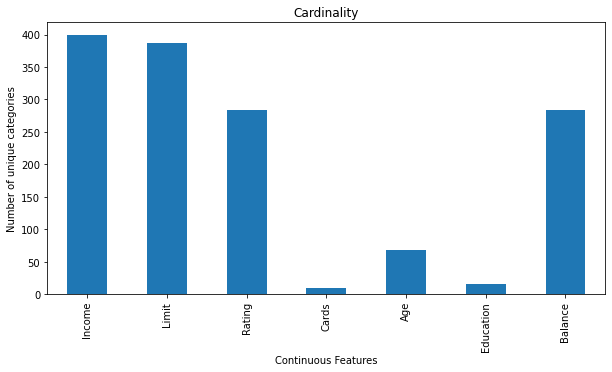

In [8]:
# cardinality
display(Markdown("#### Feature Cardinality"))
display(credit_df[cont_cols].nunique())

# visualizing cardinality of continuous features
credit_df[cont_cols].nunique().plot.bar(figsize=(10,5))
plt.ylabel('Number of unique categories')
plt.xlabel('Continuous Features')
plt.title('Cardinality')
plt.show()

# Observations:
# - The cardinality of Income, Limit, Rating, Balance, and Age seems appropriate for these continuos variables considering the business area.
# - Cards has a cardinality of 9, this may be a low cardinality, but it is appropriate since there is small range of values this feature can take (it would be unlikely for a person to have more than 10 credit cards I would assume).
# - Education is an interesting feature. Without more information about this dataset, I would assume that this feature could represent one of two things: education level (if the case, then a cardinality of 16 seems suspicious and odd), or years of education (this might be a more plausible explanation for the high cardinality of this feature). I assume this feature represents number of years of education.

#### Outliers Summary

Income: 29
Limit: 13
Rating: 11
Cards: 2
Age: 0
Education: 0
Balance: 0


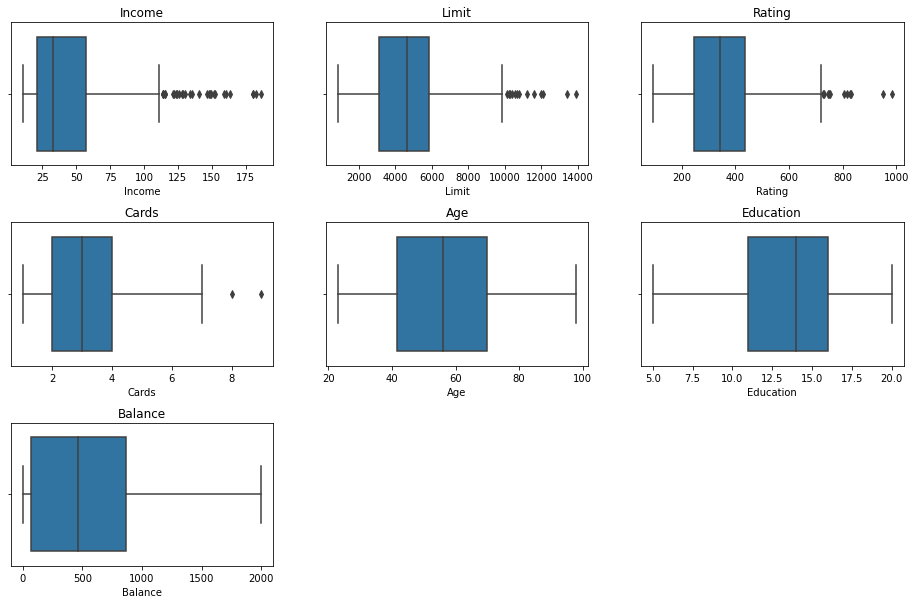

In [9]:
# summarizing outliers count
display(Markdown("#### Outliers Summary"))
for var in cont_cols:
    outliers_count = count_outliers(credit_df, var)
    print("%s: %d" %(var,outliers_count))
    
# visualizing with boxplots
x_ax = cont_cols[:]

fig_cols = 3
fig_rows = -(-len(x_ax)//fig_cols)
plots_qty = len(x_ax)

fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(16,10), gridspec_kw={'hspace': 0.4})
for i in range(plots_qty):
    row = i // fig_cols
    col = i % fig_cols
    ax_curr = axes[row, col]
    sns.boxplot(x=x_ax[i], data=credit_df, ax=ax_curr)
    ax_curr.set_title(x_ax[i])
    
to_set_off = fig_cols * fig_rows - plots_qty
for i in range(1, to_set_off+1):
    axes.flat[-i].set_visible(False)
    
# Observations:
# - There are outliers for Income, Limit, rating, and Cards.
# - It may not be common, but the high values of those outliers might be valid. People in executive positions, who are in fact a minority compared to non-executives, can have these high incomes.
# - Similarly, it makes sense to have some quite high values for Limit assuming they correspond to the minority with high Income values.
# - Following the same trend, the higher Rating values can be explained if we assume that hey correspond to people with high Income/Limit.
# - The outliers in Cards may be due to valid data considering there is no limit for how many credit cards a person can have. While according to research, more than 5 credit cards is above the average/standard, without more information about the dataset, it is difficult to determine the validity of these outliers.

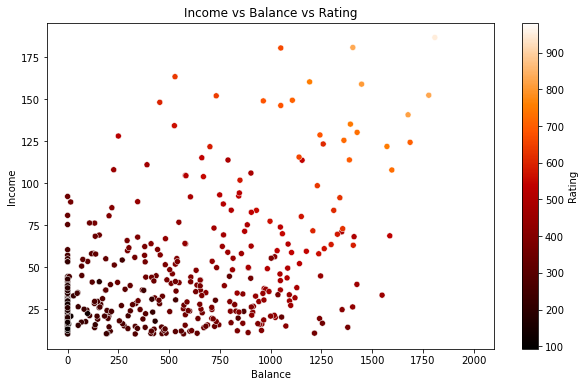

In [10]:
# exploring the assumptions made above about the relationship among Income, Balance, and Rating
fig, ax = plt.subplots(figsize=(10,6)) 
sns.scatterplot(data=credit_df, x="Balance", y="Income",  hue="Rating", palette='gist_heat').set_title('Income vs Balance vs Rating')
norm = plt.Normalize(credit_df['Rating'].min(), credit_df['Rating'].max())
sm = plt.cm.ScalarMappable(cmap="gist_heat", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm).set_label('Rating')
plt.show()

In [11]:
# determining potential thresholds for feature with outliers using the 1.5IQR criterion
outl = ['Income', 'Limit', 'Rating', 'Cards']
for var in outl:
    print(var, get_clamp_thresholds(credit_df, var))

Income (-33.688, 112.166)
Limit (-1089.125, 10049.875)
Rating (-37.75, 722.25)
Cards (-1.0, 7.0)


<AxesSubplot:>

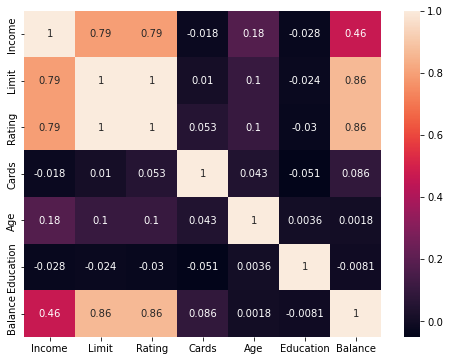

In [12]:
# collinearity
fig, ax = plt.subplots(figsize=(8,6)) 
sns.heatmap(credit_df.corr(), annot=True)

# Observations:
# - Rating and Limit depict a higher positive correlation to the target, Balance, followed by Income.
# - Rating and Limit are highly correlated to Income positively.
# - There is not a significant correlation among other features.

**Visualizing feature distributions**

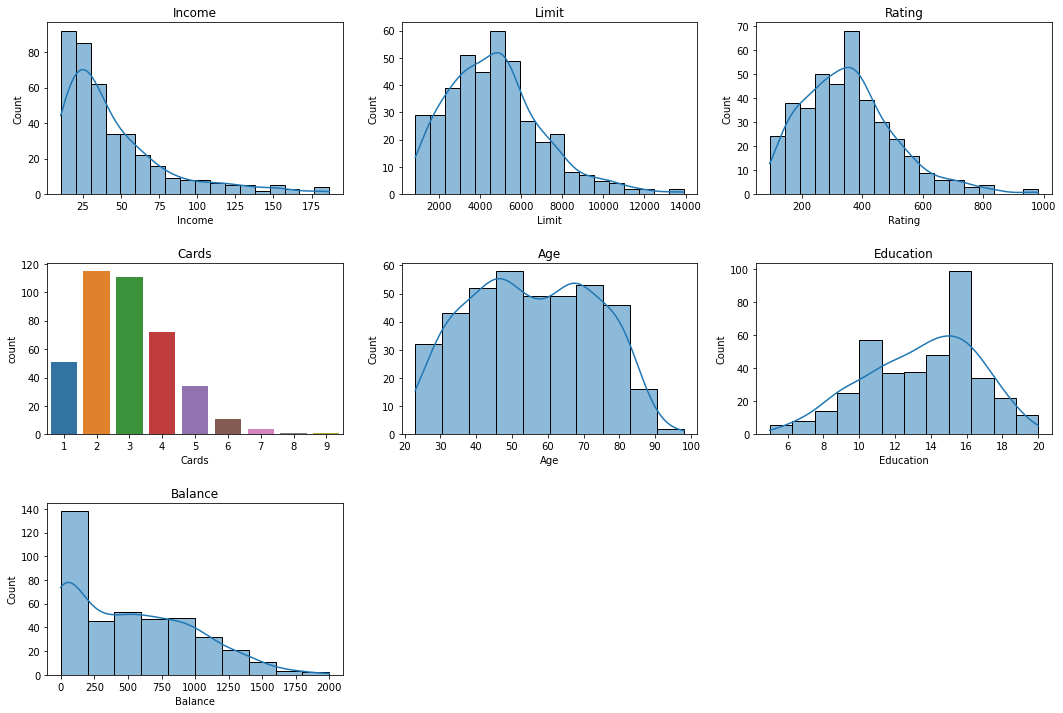

In [13]:
# x_axis
x_ax = cont_cols[:]

fig_cols = 3
fig_rows = -(-len(x_ax)//fig_cols)
plots_qty = len(x_ax)

# plotting histogram
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(18,12), gridspec_kw={'hspace': 0.4})
for i in range(plots_qty):
    row = i // fig_cols
    col = i % fig_cols
    ax_curr = axes[row, col]
    
    if(x_ax[i]=="Cards"): # 'Cards' has a cardinality less than 10. Hence, I'll use a bar plot instead of a histogram.
        sns.countplot(x=x_ax[i], data=credit_df, ax=ax_curr)
    else:
        sns.histplot(data=credit_df, x=x_ax[i], kde=True, ax=ax_curr)
        
    ax_curr.set_title(x_ax[i])
    
to_set_off = fig_cols * fig_rows - plots_qty
for i in range(1, to_set_off+1):
    axes.flat[-i].set_visible(False)
    
# Observations:
# - The majority of credit card holders in the dataset have low income with the presence of outliers at the highest income values. Income follows a skewed-right distributions. Data seems to be centred at 33 approximately, and there is higher variation in the top 50% of the data.
# - Limit, Rating, and Cards are skewed-right distributed, also with the presence of outliers at higher values. Limit is centred at ~4622, Rating at 344, and Cards at 3. In all three cases, there is higher variation in the top 50% of the data.
# - Age is centred at 55.66, which is very close to the average age in the data (56). Older ages (>80) are significantly less frequent.
# - Education is slightly skewed-left. 16 years of education is the the most frequent value. 
# - Balance follows a skewed-right distribution, higher balance values are less frequent.

**Visualizing relationships between descriptive features and target**

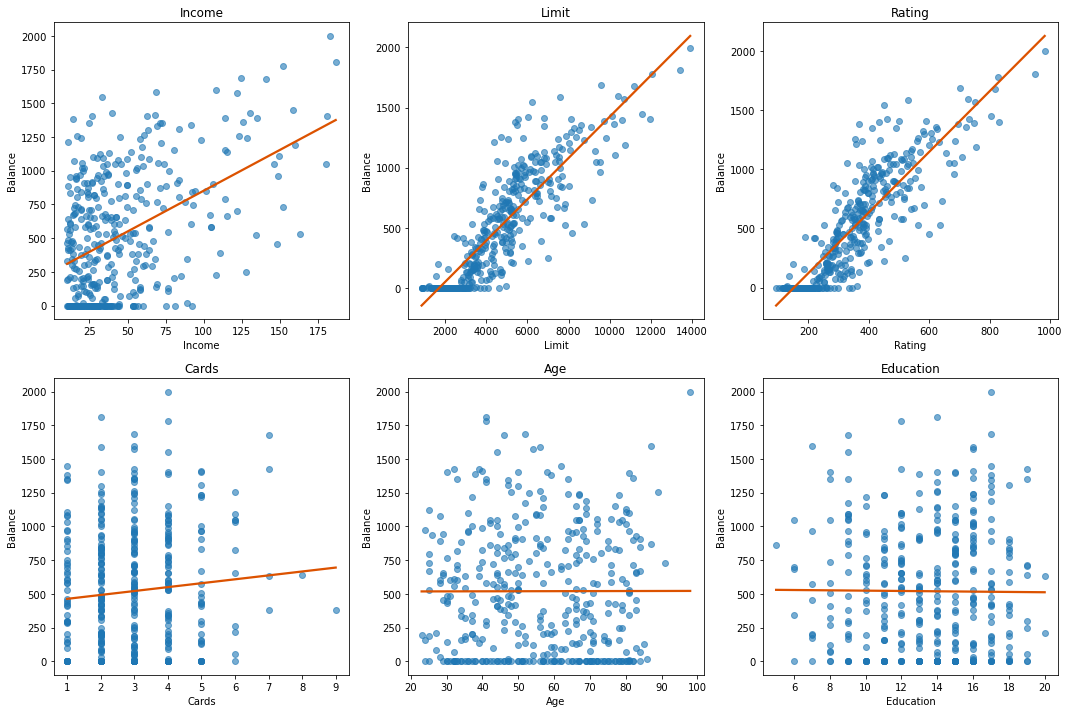

In [14]:
# x_axis
x_ax = cont_cols[:] # list of variables for the x_axis
x_ax.remove('Balance')
y_ax = 'Balance' # y_axis

fig_cols = 3
fig_rows = -(-len(x_ax)//fig_cols)
plots_qty = len(x_ax)

# plotting with reg line
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(18,12), gridspec_kw={'hspace': 0.2})
for i in range(plots_qty):
    row = i // fig_cols
    col = i % fig_cols
    ax_curr = axes[row, col]
    sns.regplot(x=x_ax[i], y=y_ax, ci=None, data=credit_df, line_kws={"color": "#dc5200"}, scatter_kws={"alpha": 0.6}, ax=ax_curr);
    ax_curr.set_title(x_ax[i])
    
to_set_off = fig_cols * fig_rows - plots_qty
for i in range(1, to_set_off+1):
    axes.flat[-i].set_visible(False)
    
# Observations:
# - The scatter plots confirm visually what was already concluded from the correlation matrix.
# - Income, Limit, and Rating are strongly correlated to Balance. Balance tends to increase as they increase.
# - Especially Limit and Rating depict a strong positive linear correlation to Balance.
# - Age and Education do not seem to impact Balance.

**Categorical Features**

In [15]:
credit_df[cat_cols].describe()

# - Cardinality for student and married seems correct.
# - Despite the fact that I am not sure of the meaning of Own, it is a binary variable, so cardinality seems correct.
# - For region, cardinality is 3. 'North' is not represented in the dataset.

,Own,Student,Married,Region
count,400,400,400,400
unique,2,2,2,3
top,Yes,No,Yes,South
freq,207,360,245,199


In [16]:
# checking modes and frequency
display(Markdown("#### Frequency of categorical features"))
for var in cat_cols:
    print(f'\nFeature: {var}')
    feature_count = credit_df[var].value_counts(dropna=False)
    feature_per = credit_df[var].value_counts(dropna=False, normalize=True) * 100
    display(pd.concat([feature_count,feature_per], axis=1, keys=['counts', '%']))

#### Frequency of categorical features


Feature: Own


,counts,%
Yes,207,51.75
No,193,48.25



Feature: Student


,counts,%
No,360,90.0
Yes,40,10.0



Feature: Married


,counts,%
Yes,245,61.25
No,155,38.75



Feature: Region


,counts,%
South,199,49.75
West,102,25.50
East,99,24.75


In [17]:
# checking missing values
credit_df[cat_cols].isna().sum()

Own        0
Student    0
Married    0
Region     0
dtype: int64

**Visualizing feature distributions**

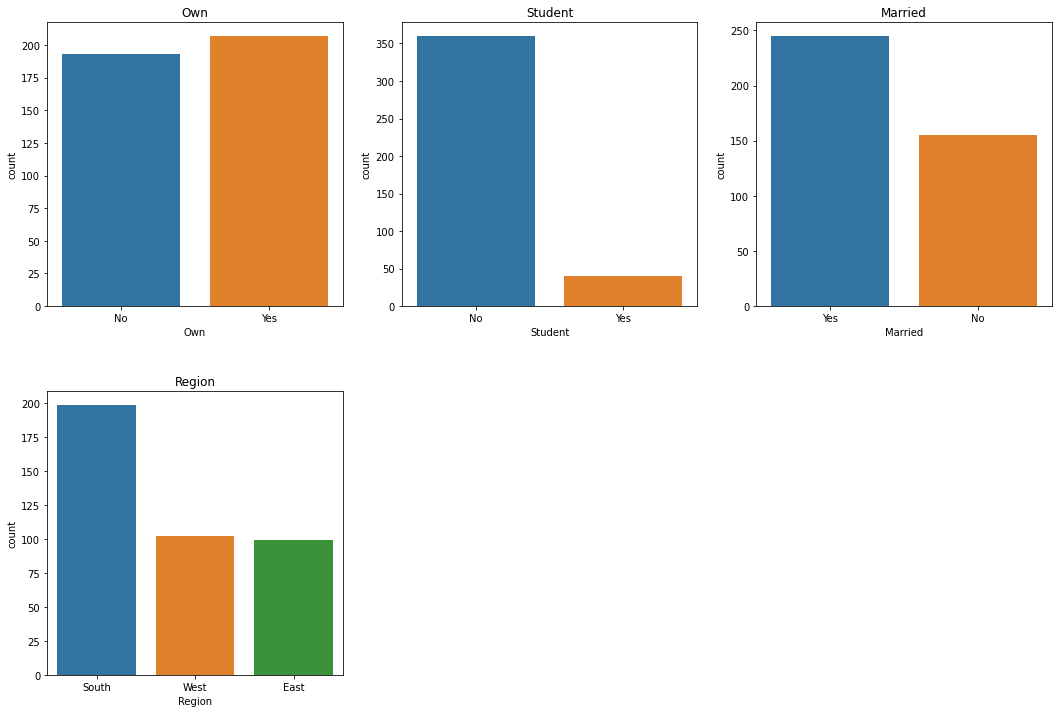

In [18]:
# x_axis
x_ax = cat_cols[:]
fig_cols = 3
fig_rows = -(-len(x_ax)//fig_cols)
plots_qty = len(x_ax)

# plotting bar plots
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(18,12), gridspec_kw={'hspace': 0.3})
for i in range(plots_qty):
    row = i // fig_cols
    col = i % fig_cols
    ax_curr = axes[row, col]
    sns.countplot(x=x_ax[i], data=credit_df, ax=ax_curr)
    ax_curr.set_title(x_ax[i])
    
to_set_off = fig_cols * fig_rows - plots_qty
for i in range(1, to_set_off+1):
    axes.flat[-i].set_visible(False)
    
# Observations:
# - Own is similarly distributed, 'Yes' is the most frequent by a small margin.
# - Credit card holders that are NOT students represent the vast majority with 90%.
# - Married people represent over 60% in the dataset.
# - The South region is the most frequent with nearly 50%, while West and East are similarly distributed at ~25%.

**Visualizing relationships between descriptive features and target**

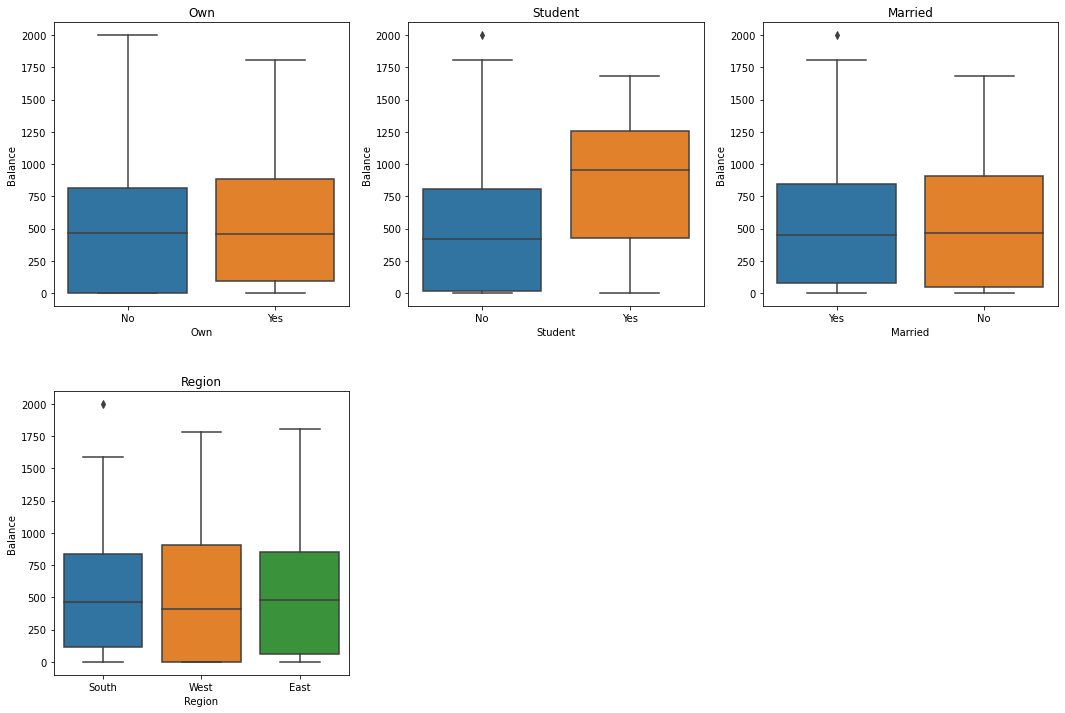

In [19]:
x_ax = cat_cols[:]
fig_cols = 3
fig_rows = -(-len(x_ax)//fig_cols)
plots_qty = len(x_ax)

# plotting boxplots
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(18,12), gridspec_kw={'hspace': 0.3})
for i in range(plots_qty):
    row = i // fig_cols
    col = i % fig_cols
    ax_curr = axes[row, col]
    sns.boxplot(x=x_ax[i], y='Balance', data=credit_df, ax=ax_curr)
    ax_curr.set_title(x_ax[i])
    
to_set_off = fig_cols * fig_rows - plots_qty
for i in range(1, to_set_off+1):
    axes.flat[-i].set_visible(False)
    
# Observations:
# - Own='No' covers a larger range of balance compared to Own='Yes'.
# - Overall, non-students tend to reach higher Balance values. There is more variation in the top 50% of non-students. In contrast, students depict an opposite trend (more variation in the bottom 50%).
# - While the variation in the bottom 50% of the data does not differ significantly between married and single people, there is more variation in balance in the top 50% for married people.
# - Overall, credit card holders from the South region tend to have a smaller range of balance with the presence of an outlier at ~2000. 